In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import pymongo
from pymongo import MongoClient
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords
import lxml

# Fetching Uncleaned Data from csv

In [2]:
df=pd.read_csv('Before_cleaning.csv',sep=',')

# Verifying the data

In [3]:
flair_list=["Coronavirus","Non-Political","Politics","Science/Technology","Policy/Economy","Photography","AskIndia","Scheduled","Sports","Food","Business/Finance","[R]eddiquette"]
df.head(10)

,Searched flair,flair,title,score,id,author,body,created,comms_num,url,time,comments
0,Coronavirus,Coronavirus,Dumped by Mumbai's upper middle and middle cla...,73,g602bs,hipporama,NaN,1.587587e+09,8,https://www.firstpost.com/health/coronavirus-o...,2020-04-23 01:46:04,I am not even at my own house. Have paid both ...
1,Coronavirus,Coronavirus,India says infection growth rate has slowed do...,7,g63l42,nishubikash,NaN,1.587599e+09,7,https://www.thehindu.com/news/national/coronav...,2020-04-23 05:21:01,\*cough\* whoreshit \*cough\* Guy: *ready to h...
2,Coronavirus,Coronavirus,"H1B holders, are you worried about a possible ...",149,g5ha81,kais92,My name is Kai Schultz. I'm a journalist with ...,1.587512e+09,108,https://www.reddit.com/r/india/comments/g5ha81...,2020-04-22 04:57:55,Maybe US isn't a very attractive immigration t...
3,Coronavirus,Coronavirus,Karnataka government has decided to partially ...,13,g65keb,_ConfusedDeveloper,NaN,1.587606e+09,2,https://www.hindustantimes.com/india-news/karn...,2020-04-23 07:08:25,"Well, now we just have to wait for the manager..."
4,Coronavirus,Coronavirus,Deep rot in West Bengal during COVID-19 lockdo...,8,g66r3z,ghatroad,NaN,1.587610e+09,0,https://www.firstpost.com/health/deep-rot-in-w...,2020-04-23 08:11:37,NaN
5,Coronavirus,Coronavirus,Bid by BECIL (Under Ministry Of Information an...,13,g619tp,india_ko_vanakkam,NaN,1.587592e+09,3,https://www.becil.com/uploads/tender/Corrigend...,2020-04-23 03:08:53,Specifications of the tool they have asked for...
6,Coronavirus,Coronavirus,"Aarogya Setu will include telemedicine, greate...",9,g63iaw,india_ko_vanakkam,NaN,1.587599e+09,1,https://www.medianama.com/2020/04/223-aarogya-...,2020-04-23 05:16:29,"What happened to ChaddiChandan's ""India Shack""..."
7,Coronavirus,Coronavirus,Indian Embassies undertake herculean task of c...,19,g5ykod,i_Killed_Reddit,NaN,1.587579e+09,0,https://economictimes.indiatimes.com/news/poli...,2020-04-22 23:46:35,NaN
8,Coronavirus,Coronavirus,Mumbai Hospital Issues Notice To Docs On Strik...,27,g5wiv8,bookshearer,NaN,1.587568e+09,0,https://www.youtube.com/watch?v=p_6j_xdANNU,2020-04-22 20:38:38,NaN
9,Coronavirus,Coronavirus,"Lockdown scenes in Kurnool, Andhra Pradesh whi...",1809,g5xgab,drunk_sithlord,NaN,1.587573e+09,113,https://i.redd.it/h77492fyybu41.jpg,2020-04-22 22:02:48,What do you expect if you allow the market to ...


# Our Data has 12 columns and 1501 datapoints

In [4]:
df.shape

(1501, 12)

# We can see that the scrapped uncleaned Data is fairly balanced for all flairs

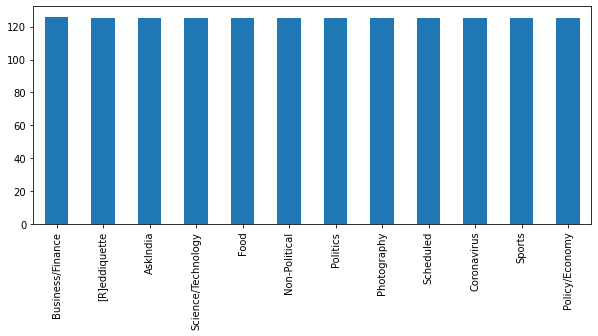

In [5]:
plt.figure(figsize=(10,4))
df["flair"].value_counts().plot(kind='bar')

In [6]:
df.columns.values

array(['Searched flair', 'flair', 'title', 'score', 'id', 'author',
       'body', 'created', 'comms_num', 'url', 'time', 'comments'],
      dtype=object)

# Mathematical analysis for columns with integral values

In [7]:
df.describe()

,score,created,comms_num
count,1501.000000,1.501000e+03,1501.000000
mean,376.235843,1.583230e+09,194.432378
std,953.100363,6.368557e+06,542.032458
min,0.000000,1.549745e+09,0.000000
25%,22.000000,1.582831e+09,8.000000
50%,78.000000,1.585787e+09,30.000000
75%,280.000000,1.587027e+09,94.000000
max,17894.000000,1.587617e+09,8339.000000


## We can observe that most of the entries in body of a post have NaN i.e. thet are empty and this might effect the accuracy of our models hence we decide to replace them with an empty string.

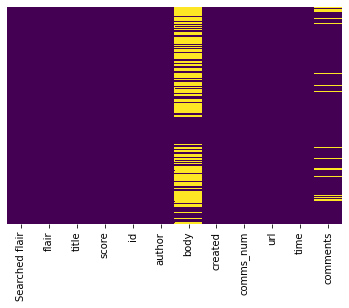

In [8]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

In [9]:
df['body'].fillna("", inplace = True) 
df['comments'].fillna("",inplace=True)

# Heatmap once all the NaN have been replaced

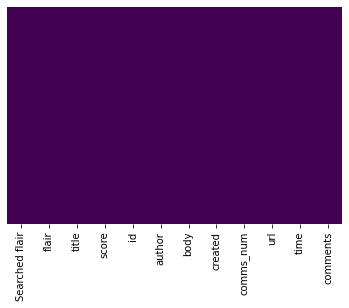

In [10]:
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap = 'viridis')

# Stopwords analysis

#### Before removing any extra words such as (is,the,or,a,etc.) we have a total of 2957159 words in comments+title+url+body

#### We remove these redundant words as they might cause confusion in our predictions and can reduce the accuracy of our model. This is because they do not provide any significant feature or trait in predicting a particular flair.

In [11]:
combination=df["comments"]+df["title"]+df["url"]+df["body"]
print(combination.apply(lambda x: len(x.split(' '))).sum())

2957159


# The uncleaned data can be seen below:

In [12]:
pd.set_option('display.max_colwidth', 200)
df['comments'].head(10)

0    I am not even at my own house. Have paid both my maids because they are good people . They didn't have to ask me and I didn't tell them that I am doing it. It all boils down to how well you treat ...
1    \*cough\* whoreshit \*cough\* Guy: *ready to hang from a ceiling fan*  \n\nIndian Government: We built the ceiling fan, it won't fall.  \n\nGuy: *hangs*  \n\nCeiling fan: *drops, guy breaks his le...
2    Maybe US isn't a very attractive immigration target any more... it's a temporary ban bought under exceptional circumstances. Also it's a blanket ban. I don't think anyone has any reason to be wear...
3    Well, now we just have to wait for the managers to come out and say "all staff are essential, sab ko aana hein Thursday sein!"\n\nOn a serious note, how will people go to office if literally every...
4                                                                                                                                                                                   

# Cleaned Data

In [13]:
cleaned=pd.read_csv('redditlimit20.csv',sep=',')
cleaned['comments_title_url_body'].head(10)

0    even house paid maids good people didnt ask didnt tell boils well treat people general lots good making money help domestic help fuck people complete morons gave maid full months salary letting go...
1    cough whoreshit cough guy ready hang ceiling fan indian government built ceiling fan wont fall guy hangs ceiling fan drops guy breaks legs indian government haha see guy didnt die hope true yeah t...
2    maybe us isnt attractive immigration target temporary ban bought exceptional circumstances also blanket ban dont think anyone reason weary get clarifications us govt hey kai hope well actually app...
3    well wait managers come say staff essential sab ko aana hein thursday seinon serious note people go office literally every mode transport shut get lathicharged dont bribe cops meet way bbmp buses ...
4    deep rot west bengal covid19 lockdown mamata banerjee good reasons touchy centres factfinding attemptshttps://www.firstpost.com/health/deep-rot-in-west-bengal-during-covid-19-

# Number of words after cleaning the data have significantly reduced

#### We now have 1698726 words in comments+title+url+body as compared to the 2957159 words
#### Hence the stopwords comprised of 42.6% of the initial words

In [14]:
print(cleaned['comments_title_url_body'].apply(lambda x: len(x.split(' '))).sum())

1698726


# Here we look at the mean number of comments on each flair category

#### We observe that Scheduled and [R]eddiquette have more than usual comments and thus number of comments also showcase some traits that might be useful in predicting flair if a post belongs to these two categories.
#### Politics also has more number of comments than the rest and cen be because of how active users become while descussing politics

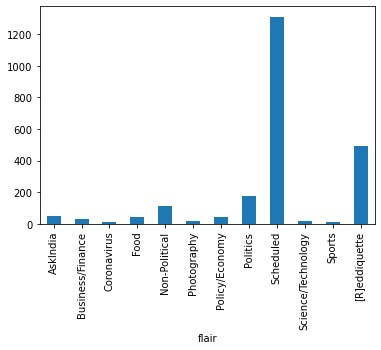

In [15]:
cleaned.groupby("flair")['comms_num'].mean()
cleaned.groupby("flair")['comms_num'].mean().plot(kind='bar')

# Here we look at the mean score of posts belonging to different flair category

### score=upvotes-downvotes

#### We can observe that Politics and Non-political have greater scores than the rest and hence while predicting scores can help if a post belong to any of the two categories

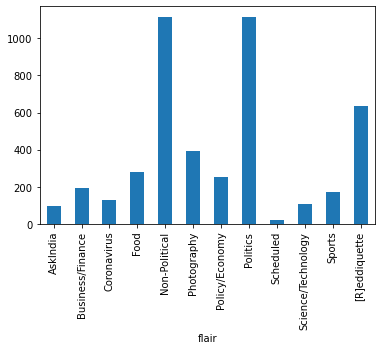

In [16]:
cleaned.groupby("flair")['score'].mean()
cleaned.groupby("flair")['score'].mean().plot(kind='bar')